# CIFAR 10
CIFAR-10是一個常用的圖像分類資料集，由加拿大計算機視覺和自然學習研究所（CIFAR）提供。它包含10個類別（如飛機、汽車、鳥、貓等）共60000張32x32像素的彩色圖像，每個類別有6000張圖像。這個資料集通常用於機器學習和深度學習模型的基準測試，以評估它們在圖像分類任務上的性能。CIFAR-10的相對較小的圖像尺寸和挑戰性的分類任務使其成為評估新算法和模型性能的流行選擇之一

# CIFAR10 Practice
1. 匯入資料進 dataset
2. 確認資料、random產生資料
3. 資料 Normalization
4. 寫入dataset & dataloader
5. 建立model
6. 建立train loop
7. 建立test loop
8. 將資料丟進train & test loop
9. 模型修正
10. 模型儲存
11. Confusion Matrix
12. 結論

In [308]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from torchinfo import summary
from tqdm.auto import tqdm
import ssl
import random
import warnings

In [4]:
torch.cuda.is_available()

True

# 1.匯入資料進 dataset

In [11]:
path = '/python_files/'

In [18]:
ssl._create_default_https_context = ssl._create_unverified_context # datasets.CIFAR10 沒有憑證，需以此來下載避免報錯

In [52]:
# 先做簡易的transform將資料從PIL轉成tensor
train = datasets.CIFAR10(root = path, train = True, download = True, transform = torchvision.transforms.ToTensor()) 

Files already downloaded and verified


In [45]:
test = datasets.CIFAR10(root = path, train = False, download = True, transform = torchvision.transforms.ToTensor())

Files already downloaded and verified


# 2. 確認資料、random產生資料

In [149]:
train, test

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: /python_files/
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: /python_files/
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [150]:
train.classes, test.class_to_idx

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

In [288]:
img, label = train[0]
img, img.shape, train.classes[label]

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

(-0.5, 31.5, 31.5, -0.5)

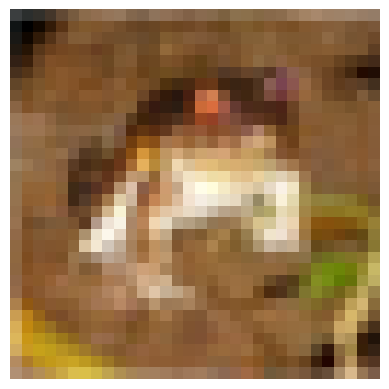

In [106]:
# 因為 matplotlib吃的資料是numpy且為 H*W*C 的型態，而Tensor轉換後的資料為 H*W*C，如果要用 plt 來畫出圖像需要將維度重新調整
plt.imshow(img.permute(1,2,0).numpy())
plt.axis(False)

In [319]:
def random_sample(dataset, n):

    '''
    Random跑出sample，來看大概資料的長相
    '''
    
    ran_list = random.sample(range(len(dataset)), n)   
    for i in range(n):        
        plt.subplot(n//5+1, 5, i+1)
        img, label = dataset[ran_list[i]]
        # if torch.min(img)<0:
        #     plt.imshow((img.permute(1,2,0).numpy()/255).astype(np.uint8))
        # else:
        plt.imshow(img.permute(1,2,0).numpy())
        plt.title(dataset.classes[label])
        plt.axis(False)
      
    plt.tight_layout()
    plt.show()


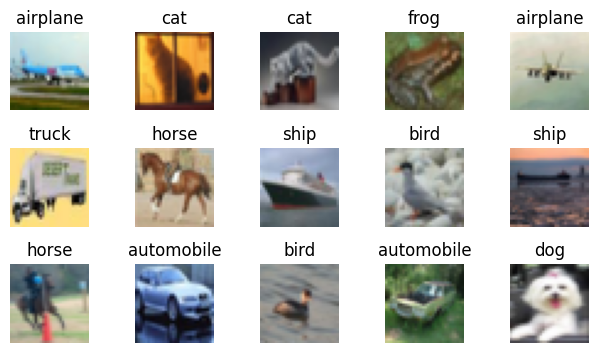

In [313]:
random_sample(train, 15)

In [116]:
from collections import Counter

In [120]:
Counter(train.targets), Counter(test.targets)

(Counter({6: 5000,
          9: 5000,
          4: 5000,
          1: 5000,
          2: 5000,
          7: 5000,
          8: 5000,
          3: 5000,
          5: 5000,
          0: 5000}),
 Counter({3: 1000,
          8: 1000,
          0: 1000,
          6: 1000,
          1: 1000,
          9: 1000,
          5: 1000,
          7: 1000,
          4: 1000,
          2: 1000}))

# 3. 資料 Normalization

在機器學習中，Normalization是一個關鍵的步驟，它有助於提高模型的性能和訓練過程的穩定性。Normalization通常應用在特徵或輸入數據上，將它們縮放到一個相對較小的範圍，通常是0到1或-1到1之間。這樣做有幾個重要的原因。首先，它有助於消除特徵之間的尺度差異，確保模型在處理不同單位和範圍的特徵時能夠以一致的方式進行學習。其次，它有助於加速優化過程，例如梯度下降，因為它使權重更新更加穩定並且更快收斂。此外，Normalization有助於減少過擬合的風險，因為它限制了數據的範圍，使得模型更難記住訓練數據中的噪聲。

### 筆記: 對資料進行 Normalization: 先將資料堆疊，並重新reshape後進行計算
* Normalization 會有助於模型收斂

* torch.Tensor.view
1. view 僅可用於 Continguous data，也就是tensor儲存位置應為連續，如果資料不為連續，可以用Continguous()後再加上view
2. view 的參數為想要成為的shape，參數之中可以放一個-1，讓torch自己去計算到底會是多少
3. view 對資料reshape後排列方式如同全部拉直之後重新放入


In [272]:
# torch.stack
a = torch.tensor([[[1, 2, 3], [4, 5, 6], [7, 8, 9]],
                  [[10, 20, 30], [40, 50, 60], [70, 80, 90]]])
b = torch.tensor([[[11, 22, 33], [44, 55, 66], [77, 88, 99]], 
                  [[110, 220, 330], [440, 550, 660], [770, 880, 990]]])
c = torch.stack([a,b], 1)
d = torch.stack([a,b], 2)
a.shape, b.shape, c.shape, d.shape, c,d

(torch.Size([2, 3, 3]),
 torch.Size([2, 3, 3]),
 torch.Size([2, 2, 3, 3]),
 torch.Size([2, 3, 2, 3]),
 tensor([[[[  1,   2,   3],
           [  4,   5,   6],
           [  7,   8,   9]],
 
          [[ 11,  22,  33],
           [ 44,  55,  66],
           [ 77,  88,  99]]],
 
 
         [[[ 10,  20,  30],
           [ 40,  50,  60],
           [ 70,  80,  90]],
 
          [[110, 220, 330],
           [440, 550, 660],
           [770, 880, 990]]]]),
 tensor([[[[  1,   2,   3],
           [ 11,  22,  33]],
 
          [[  4,   5,   6],
           [ 44,  55,  66]],
 
          [[  7,   8,   9],
           [ 77,  88,  99]]],
 
 
         [[[ 10,  20,  30],
           [110, 220, 330]],
 
          [[ 40,  50,  60],
           [440, 550, 660]],
 
          [[ 70,  80,  90],
           [770, 880, 990]]]]))

In [182]:
# view:
a = torch.Tensor(np.arange(0,12))
b = a.view(2,3,-1)
c = b.view(3,-1)
d = b.reshape(3,4)
e = b.permute(1,2,0)
a, b, c, d, e, b.shape, a.mean(), b.mean(dim = 2)

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 tensor([[[ 0.,  1.],
          [ 2.,  3.],
          [ 4.,  5.]],
 
         [[ 6.,  7.],
          [ 8.,  9.],
          [10., 11.]]]),
 tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]]),
 tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.]]),
 tensor([[[ 0.,  6.],
          [ 1.,  7.]],
 
         [[ 2.,  8.],
          [ 3.,  9.]],
 
         [[ 4., 10.],
          [ 5., 11.]]]),
 torch.Size([2, 3, 2]),
 tensor(5.5000),
 tensor([[ 0.5000,  2.5000,  4.5000],
         [ 6.5000,  8.5000, 10.5000]]))

In [244]:
train_n  = torch.stack([img for (img, label) in train], dim = 3)

In [271]:
train_n.shape 

torch.Size([3, 32, 32, 50000])

In [246]:
train_mean1 = train_n.view(3,-1).mean(dim = 1)
train_mean1

tensor([0.4914, 0.4822, 0.4465])

In [273]:
train_std1 = train_n.view(3,-1).std(dim = 1)
train_std1

tensor([0.2470, 0.2435, 0.2616])

In [277]:
# 得到mean, std後重新transform
transform_n = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), #將RPG資料全部/255變成(0,1)的數字
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [280]:
train1 = torchvision.datasets.CIFAR10(root = path, train = True, download = False, transform = transform_n)
test1 = torchvision.datasets.CIFAR10(root = path, train = False, download = False, transform = transform_n)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


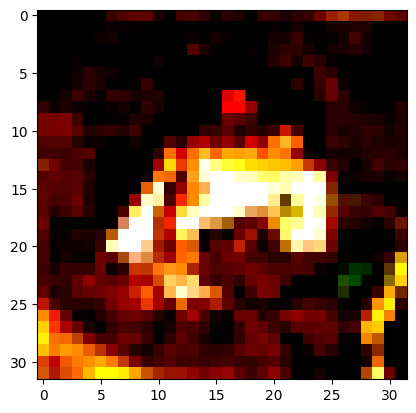

In [291]:
img1, label1 = train1[0]
plt.imshow(img1.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

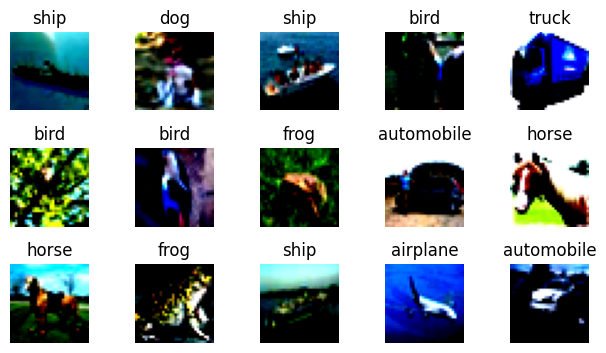

In [494]:
random_sample(train1, 15)

# 4. 寫入dataloader

In [321]:
train1, test1

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: /python_files/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: /python_files/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
            ))

In [323]:
# 設定batch size的好處: 1. 平行運算導致計算比較快 2. 在進行optimize的時候可以用一個batch的基準較為穩定的進行更新
# shuffle: 因為有些training資料並不是混好的，所以training很多都會先shuffle再training
train_loader = torch.utils.data.DataLoader(train1, batch_size = 16, shuffle = True)
test_loader = torch.utils.data.DataLoader(test1, batch_size = 16, shuffle = False)

In [324]:
img2, label2 = next(iter(train_loader))
img2.shape, img2, label2

(torch.Size([16, 3, 32, 32]),
 tensor([[[[-1.0369e+00, -1.0527e+00, -1.0686e+00,  ..., -1.2115e+00,
            -1.2433e+00, -1.2909e+00],
           [-6.0819e-01, -5.7644e-01, -6.3995e-01,  ..., -4.9705e-01,
            -6.8758e-01, -8.6222e-01],
           [ 1.5389e-01,  1.5389e-01,  7.4510e-02,  ..., -3.6628e-02,
            -8.4258e-02, -1.3189e-01],
           ...,
           [ 1.2176e+00,  1.2176e+00,  1.2811e+00,  ...,  6.6195e-01,
             8.8423e-01,  9.4773e-01],
           [ 1.2176e+00,  1.2176e+00,  1.2811e+00,  ...,  1.0906e+00,
             1.0112e+00,  9.6361e-01],
           [ 1.2335e+00,  1.2494e+00,  1.3288e+00,  ...,  1.1065e+00,
             1.0589e+00,  9.9536e-01]],
 
          [[-1.8192e+00, -1.8353e+00, -1.8514e+00,  ..., -1.7387e+00,
            -1.7709e+00, -1.8353e+00],
           [-1.2072e+00, -1.1750e+00, -1.2234e+00,  ..., -7.5631e-01,
            -9.3346e-01, -1.1267e+00],
           [ 6.5048e-02,  6.5048e-02, -1.5477e-02,  ..., -9.6002e-02,
         

In [468]:
train_loader1 = torch.utils.data.DataLoader(train1, batch_size = 64, shuffle = True)
test_loader1 = torch.utils.data.DataLoader(test1, batch_size = 64, shuffle = False)

# 5. 建立model

### Convolution Neural Network

卷積神經網絡（CNN）是一種在機器學習和深度學習中廣泛使用的神經網絡架構。CNN特別適用於處理圖像和視覺數據。它的主要特點是包含了卷積層和池化層，以及密集連接的神經網絡層。卷積層通過應用多個過濾器來從輸入圖像中提取特徵，這些過濾器通過卷積操作進行運算。接著，通過池化層來減少計算量並提取特徵的局部不變性。最後，通過密集連接的神經網絡層來將提取的特徵映射到輸出類別。CNN通常用於圖像分類、物體檢測、圖像分割等任務，它們在處理圖像數據時表現出型。
1. 大多圖形辨別都是用CNN Convolutional Neural Network來進行，CNN基本架構是 cnn + activation layer + pooling
2. CNN後面會接 flatten將模型輸出拉直後進linear model (Fully connected neural network)後來進行分類

In [333]:
class CIFAR(nn.Module):
    def __init__(self, input_f, hidden_f, output_f):
        super().__init__()
        self.se1 = nn.Sequential(
            nn.Conv2d(input_f, hidden_f, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_f, hidden_f, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_f, hidden_f, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_f, hidden_f, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8*8*hidden_f, 512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.ReLU(),
            nn.Linear(64,output_f)    
        )

    def forward(self,x):
        return self.se1(x)

In [584]:
model0 = CIFAR(3,12,10)

In [585]:
summary(model0, (16,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR                                    [16, 10]                  --
├─Sequential: 1-1                        [16, 10]                  --
│    └─Conv2d: 2-1                       [16, 12, 32, 32]          336
│    └─ReLU: 2-2                         [16, 12, 32, 32]          --
│    └─Conv2d: 2-3                       [16, 12, 32, 32]          1,308
│    └─ReLU: 2-4                         [16, 12, 32, 32]          --
│    └─MaxPool2d: 2-5                    [16, 12, 16, 16]          --
│    └─Conv2d: 2-6                       [16, 12, 16, 16]          1,308
│    └─ReLU: 2-7                         [16, 12, 16, 16]          --
│    └─Conv2d: 2-8                       [16, 12, 16, 16]          1,308
│    └─ReLU: 2-9                         [16, 12, 16, 16]          --
│    └─MaxPool2d: 2-10                   [16, 12, 8, 8]            --
│    └─Flatten: 2-11                     [16, 768]                 --
│    

In [586]:
# 試跑在資料上，報錯 :Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor"
# pytorch中資料與model需要在同一個device上，全部放到cuda
with torch.inference_mode():
    model0 = model0.to('cuda')
    img2 = img2.to('cuda')
    output = model0(img2)
output, output.shape
# 資料輸出為logit，看起來正常，來建立train loop

(tensor([[-1.0314e-02,  2.4242e-02,  3.1915e-03,  5.4099e-03, -3.0085e-02,
           1.2095e-03, -1.0299e-01,  1.2136e-01, -8.9570e-02,  4.4281e-02],
         [-1.0075e-02,  2.1713e-02,  2.7547e-03,  4.5920e-03, -3.1059e-02,
           1.9602e-03, -1.0489e-01,  1.2112e-01, -9.1109e-02,  4.3262e-02],
         [-1.0386e-02,  2.3143e-02,  3.4877e-03,  4.8548e-03, -2.9606e-02,
           1.0890e-03, -1.0290e-01,  1.2254e-01, -8.9497e-02,  4.4717e-02],
         [-8.9460e-03,  2.4223e-02,  2.4765e-03,  5.1916e-03, -2.8549e-02,
           2.9530e-03, -1.0232e-01,  1.1953e-01, -9.0920e-02,  4.3815e-02],
         [-8.7364e-03,  2.4663e-02,  4.4650e-03,  5.5099e-03, -2.9422e-02,
           1.0849e-03, -1.0315e-01,  1.2194e-01, -9.1420e-02,  4.3635e-02],
         [-8.8838e-03,  2.5015e-02,  2.6143e-03,  4.1190e-03, -3.0164e-02,
           1.4553e-03, -1.0378e-01,  1.2117e-01, -8.8891e-02,  4.3020e-02],
         [-1.0121e-02,  2.4698e-02,  5.2531e-03,  4.3812e-03, -3.0679e-02,
           1.5354e-

# 6. 建立train loop

In [416]:
def train_loop(n_epoch, model, loss_fn, optimizer, train_loader = train_loader, device = 'cuda'):

    '''
    循環n_epoch次epoch後，就model架構對train_loader依照loss_fn與optimizer進行optimize
    並印出每次epoch後的loss
    '''
    

    for epoch in tqdm(range(n_epoch)):

        tloss, ttl = 0, 0
        
        for img, label in train_loader:
            img, label = img.to(device), label.to(device)

            output = model(img)
            loss = loss_fn(output, label)
            tloss+= loss.item()
            ttl+= len(label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch}: loss: {tloss/ttl :3.4f}')


In [587]:
n_epoch = 5
model0_1 = CIFAR(3,12,10).to('cuda')
loss_fn0_1 = torch.nn.CrossEntropyLoss()
optimizer0_1 = torch.optim.Adam(model0_1.parameters())
train_loop(n_epoch, model0_1, loss_fn0_1, optimizer0_1)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0: loss: 0.0927
Epoch 1: loss: 0.0659
Epoch 2: loss: 0.0548
Epoch 3: loss: 0.0476
Epoch 4: loss: 0.0414


# 7. 建立test loop

In [544]:
def test_loop(model, loss_fn, test_loader = test_loader, device = 'cuda'):

    model.eval()

    test_loss, ttl = 0, 0
    
    with torch.inference_mode():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)

            output = model(img)
            loss = loss_fn(output, label)
            test_loss+= loss.item()
            ttl+= len(label)

    return test_loss/ttl
    
    

In [588]:
test_loop(model0_1, loss_fn0_1)

0.056851374147832395

# 8. 將資料丟進train & test loop

將上面的train_loop & test_loop稍作改寫並合併為一個，增加計算accuracy、並return loss & accuracy

In [406]:
def train_loop1(model, loss_fn, optimizer, train_loader = train_loader, device = 'cuda'):

    train_loss, train_acc, train_total = 0, 0, 0
    
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)

        output = model(img)
        loss = loss_fn(output, label)
        pre = torch.argmax(output, dim = 1)
        
        train_loss+= loss.item()
        train_acc+= int((pre == label).sum())
        train_total += len(label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return train_loss/train_total, train_acc/train_total


    

In [589]:
model0_2 = CIFAR(3,2,10).to('cuda')
loss_fn0_2 = torch.nn.CrossEntropyLoss()
optimizer0_2 = torch.optim.Adam(model0_2.parameters())
train_loop1(model0_2, loss_fn0_2, optimizer0_2)

(0.11344204926371575, 0.34404)

In [413]:
def test_loop1(model, loss_fn, test_loader = test_loader, device = 'cuda'):

    model.eval()

    test_loss, test_acc, test_total = 0, 0, 0
    
    with torch.inference_mode():
        for img, label in test_loader:
            img, label = img.to(device), label.to(device)

            output = model(img)
            loss = loss_fn(output, label)
            pre = torch.argmax(output, dim = 1)
            
            test_loss+= loss.item()
            test_acc += int((pre == label).sum())
            test_total += len(label)

    return test_loss/test_total, test_acc/test_total
    
    

In [590]:
test_loop1(model0_2, loss_fn0_2)

(0.10064617720842362, 0.4223)

In [436]:
def train_test_loop(n_epoch, model, loss_fn, optimizer, train_loader = train_loader, test_loader = test_loader, device = 'cuda'):

    train_loss, train_acc, test_loss, test_acc = [], [], [], []

    model = model.to(device)
    
    for epoch in tqdm(range(n_epoch)):
        train_l, train_a = train_loop1(model, loss_fn, optimizer, train_loader = train_loader, device = 'cuda')
        test_l, test_a = test_loop1(model, loss_fn, test_loader = test_loader, device = 'cuda')

        train_loss.append(train_l)
        train_acc.append(train_a)
        test_loss.append(test_l)
        test_acc.append(test_a)

    #plotting
    plt.figure(figsize = (10,4))
    plt.subplot(1,2,1)
    plt.plot(range(len(train_loss)), train_loss, label = 'Train Loss')
    plt.plot(range(len(train_loss)), test_loss, label = 'Test Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(len(train_loss)), train_acc, label = 'Train Accuracy')
    plt.plot(range(len(train_loss)), test_acc, label = 'Test Accuracy')
    plt.legend()
    plt.tight_layout()


    return train_loss, train_acc, test_loss, test_acc
        
    

  0%|          | 0/15 [00:00<?, ?it/s]

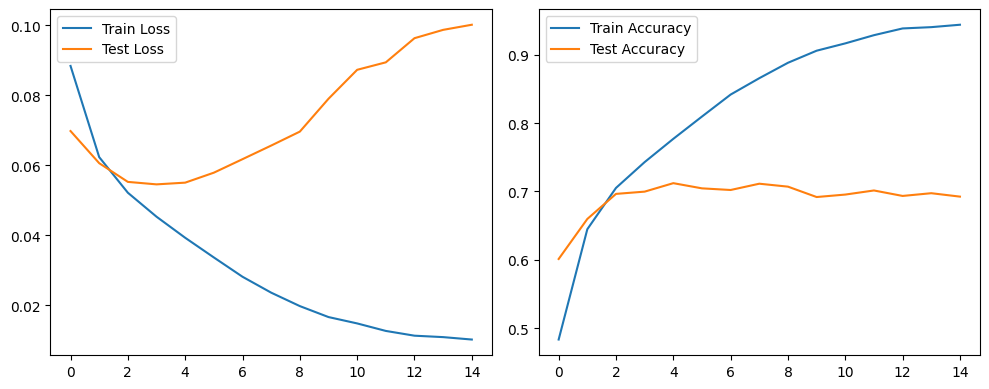

In [591]:
n_epoch = 15
model0_3 = CIFAR(3, 16, 10).to('cuda')
loss_fn0_3= torch.nn.CrossEntropyLoss()
optimizer0_3 = torch.optim.Adam(model0_3.parameters())

train_loss0_3, train_acc0_3, test_loss0_3, test_acc0_3 = train_test_loop(n_epoch, model0_3, loss_fn0_3, optimizer0_3)

In [592]:
summary(model0_3, (16,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR                                    [16, 10]                  --
├─Sequential: 1-1                        [16, 10]                  --
│    └─Conv2d: 2-1                       [16, 16, 32, 32]          448
│    └─ReLU: 2-2                         [16, 16, 32, 32]          --
│    └─Conv2d: 2-3                       [16, 16, 32, 32]          2,320
│    └─ReLU: 2-4                         [16, 16, 32, 32]          --
│    └─MaxPool2d: 2-5                    [16, 16, 16, 16]          --
│    └─Conv2d: 2-6                       [16, 16, 16, 16]          2,320
│    └─ReLU: 2-7                         [16, 16, 16, 16]          --
│    └─Conv2d: 2-8                       [16, 16, 16, 16]          2,320
│    └─ReLU: 2-9                         [16, 16, 16, 16]          --
│    └─MaxPool2d: 2-10                   [16, 16, 8, 8]            --
│    └─Flatten: 2-11                     [16, 1024]                --
│    

  0%|          | 0/15 [00:00<?, ?it/s]

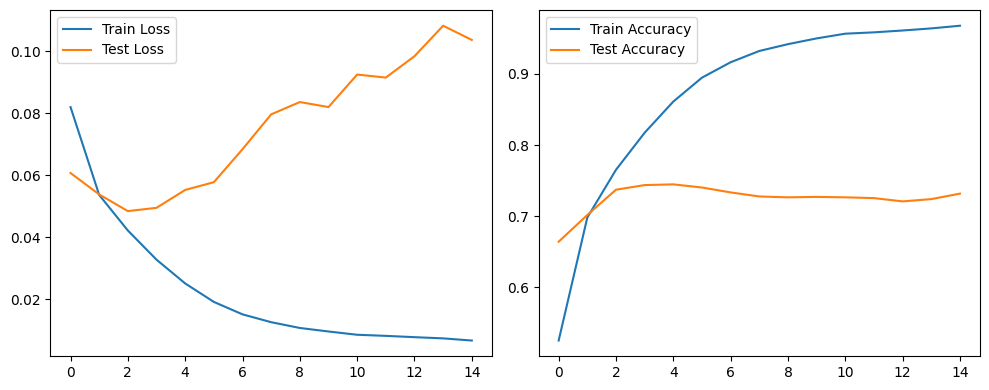

In [594]:
n_epoch = 15
model0_4 = CIFAR(3,64, 10).to('cuda')
loss_fn0_4 = torch.nn.CrossEntropyLoss()
optimizer0_4 = torch.optim.Adam(model0_4.parameters())
train_loss0_4, train_acc0_4, test_loss0_4, test_acc0_4 = train_test_loop(n_epoch, model0_4, loss_fn0_4, optimizer0_4)

在 model 的 hidden layer neuron 增加後，model accuracy 表現有變得比較好。

# 9. 模型修正

### 從 Training loss 和 Testing loss 來看:
* 大約從第三次epoch之後，testing loss增加，為模型 overfitting，避免模型overfitting的方式有:
    1. 簡化模型
    2. Dropout 在模型當中增加dropout層，也就是在layer output直接隨機drop掉所設定的%的參數進到下一層
    3. Regularization 主要是L2與L2 Regularization，藉由對於weight來限制避免模型overfitting
    4. Data Augmentation 將資料進行加工，增加dataset的多樣性，讓 model 可以對沒有看過的 testing 資料的分類更加準確
    5. Early stopping 但由於epoch才開始三次，先不考慮

## 9.1 簡化模型
主要概念是因為原本模型如果太複雜，模型很容易受到training data的影響而使模型train完之後，缺少generalize。


In [466]:
## 簡化模型 原本模型做兩次的 conv2d -> relu -> Maxpool 改成一個

class CIFAR_1(nn.Module):
    def __init__(self, input_f, hidden_f, output_f):
        super().__init__()
        self.se1 = nn.Sequential(
            nn.Conv2d(input_f, hidden_f, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16*16*hidden_f, 512),
            nn.ReLU(),
            nn.Linear(512,output_f)    
        )

    def forward(self,x):
        return self.se1(x)

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

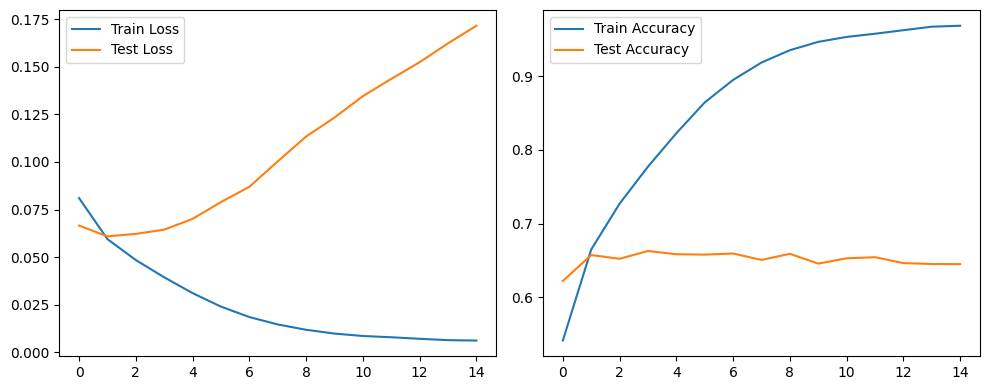

In [755]:
n_epoch = 15
model1_1 = CIFAR_1(3, 64, 10).to('cuda')
loss_fn1_1= torch.nn.CrossEntropyLoss()
optimizer1_1 = torch.optim.Adam(model1_1.parameters())

train_loss1_1, train_acc1_1, test_loss1_1, test_acc1_1 = train_test_loop(n_epoch, model1_1, loss_fn1_1, optimizer1_1)

In [448]:
summary(model1_1, (16,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR_1                                  [16, 10]                  --
├─Sequential: 1-1                        [16, 10]                  --
│    └─Conv2d: 2-1                       [16, 16, 32, 32]          448
│    └─ReLU: 2-2                         [16, 16, 32, 32]          --
│    └─Conv2d: 2-3                       [16, 16, 32, 32]          2,320
│    └─ReLU: 2-4                         [16, 16, 32, 32]          --
│    └─MaxPool2d: 2-5                    [16, 16, 16, 16]          --
│    └─Flatten: 2-6                      [16, 4096]                --
│    └─Linear: 2-7                       [16, 512]                 2,097,664
│    └─ReLU: 2-8                         [16, 512]                 --
│    └─Linear: 2-9                       [16, 64]                  32,832
│    └─ReLU: 2-10                        [16, 64]                  --
│    └─Linear: 2-11                      [16, 10]                  650

將 Batch Size 從 16 改成 64後，run time 與 Loss都有所減少，但 Overfitting依然存在。

  0%|          | 0/15 [00:00<?, ?it/s]

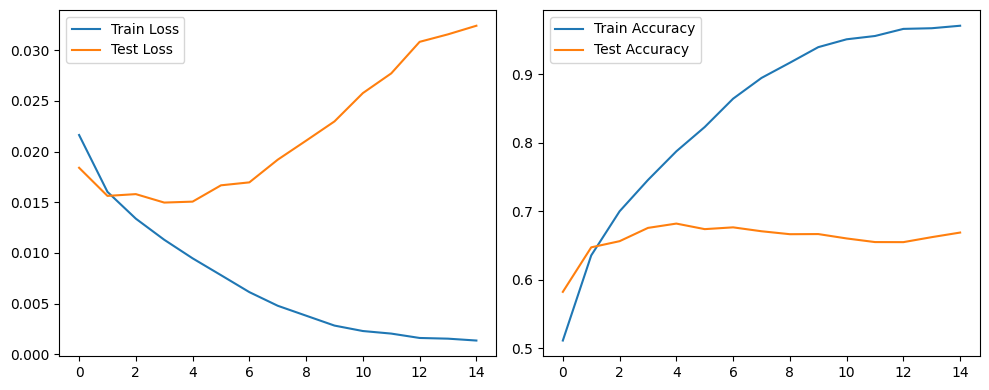

In [757]:
n_epoch = 15
model1_2 = CIFAR_1(3, 64, 10).to('cuda')
loss_fn1_2= torch.nn.CrossEntropyLoss()
optimizer1_2 = torch.optim.Adam(model1_2.parameters())

train_loss1_2, train_acc1_2, test_loss1_2, test_acc1_2 = train_test_loop(n_epoch, model1_2, loss_fn1_2, optimizer1_2, train_loader = train_loader1, test_loader= test_loader1)

用簡化模型將hidden layer的neron從16改成64，以結果來看對模型影響並不大。這邊嘗試修改 hidden layer 中的 neuron 數:

  0%|          | 0/15 [00:00<?, ?it/s]

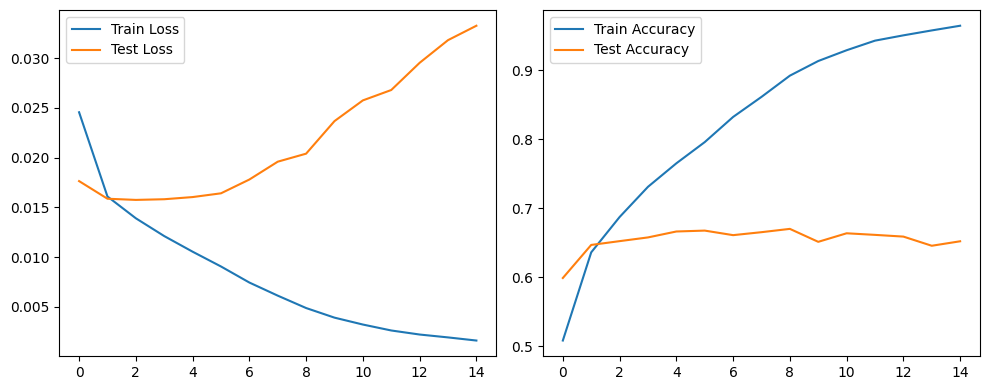

In [758]:
n_epoch = 15
model1_3 = CIFAR_1(3, 256, 10).to('cuda')
loss_fn1_3= torch.nn.CrossEntropyLoss()
optimizer1_3 = torch.optim.Adam(model1_3.parameters())

train_loss1_3, train_acc1_3, test_loss1_3, test_acc1_3 = train_test_loop(n_epoch, model1_3, loss_fn1_3, optimizer1_3, train_loader = train_loader1, test_loader= test_loader1)

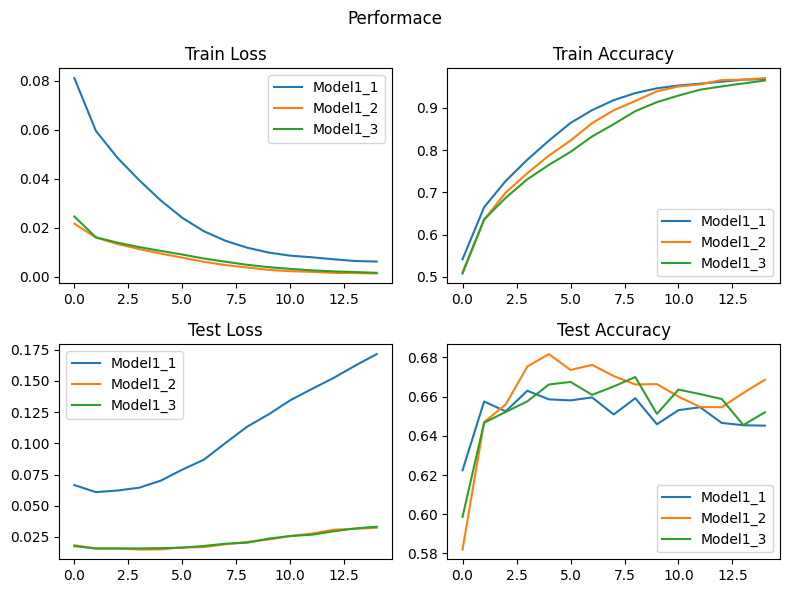

In [759]:
plt.figure(figsize = (8,6))
plt.subplot(2,2,1)
plt.plot(range(15), train_loss1_1, label = 'Model1_1')
plt.plot(range(15), train_loss1_2, label = 'Model1_2')
plt.plot(range(15), train_loss1_3, label = 'Model1_3')
plt.legend(loc = 'best')
plt.title('Train Loss')

plt.subplot(2,2,2)
plt.plot(range(15), train_acc1_1, label = 'Model1_1')
plt.plot(range(15), train_acc1_2, label = 'Model1_2')
plt.plot(range(15), train_acc1_3, label = 'Model1_3')
plt.legend(loc = 'best')
plt.title('Train Accuracy')
plt.suptitle('Train Performace')

plt.subplot(2,2,3)
plt.plot(range(15), test_loss1_1, label = 'Model1_1')
plt.plot(range(15), test_loss1_2, label = 'Model1_2')
plt.plot(range(15), test_loss1_3, label = 'Model1_3')
plt.legend(loc = 'best')
plt.title('Test Loss')

plt.subplot(2,2,4)
plt.plot(range(15), test_acc1_1, label = 'Model1_1')
plt.plot(range(15), test_acc1_2, label = 'Model1_2')
plt.plot(range(15), test_acc1_3, label = 'Model1_3')
plt.legend(loc = 'best')
plt.title('Test Accuracy')
plt.suptitle('Performace')

plt.tight_layout()



* Loss:
Training 和 testing 的  Loss 都在 data 的 batch size 從 16 變成 64 後變得更低，但是 testing loss 隨著 epoch 有越來越高的趨勢，代表還是有 overfitting 的狀況。
(Model1_2 和 Model1_3在圖中看起來 overfitting 狀況還好的原因是因為 Model1_1的 overfitting 狀況嚴重)
* Accuracy:
Training 的準確度隨著 Epoch 增加都有很好的表現，而 testing 的準確度 batch size 增加後有高一些，但 Model1_2 和 Model1_3 的表現並沒有差異很多。

 整體來看單簡化模型的準確度比原本模型還要差，但在 Loss 的部分，隨著 batch size 的改變有所下降。且這裡在測試 hidden layer neron 數時，發現在 64 的 Accuracy 表現會比 256 好。

## 9.2 Dropout
在機器學習中，Dropout是一種正規化技術，用於減少神經網絡模型的過擬合。Dropout通常應用在神經網絡的訓練過程中，它的作用是在每次訓練迭代中隨機地丟棄（即“dropout”）一部分神經元，從而減少神經網絡的複雜度和容量。這樣做可以強迫模型去學習多個互相獨立的特徵表示，從而提高模型的泛化能力。

In [510]:
class CIFAR_2(nn.Module):
        def __init__(self, input_f, hidden_f, output_f):
            super().__init__()
            self.se1 = nn.Sequential(
                nn.Conv2d(input_f, hidden_f, kernel_size= 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_f, hidden_f, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.5),
                nn.Conv2d(hidden_f, hidden_f, kernel_size= 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_f, hidden_f, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.5),
                nn.Flatten(),
                nn.Linear(8*8*hidden_f, 512),
                nn.ReLU(),
                nn.Linear(512,64),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(64,output_f)    
            )

        def forward(self,x):
            return self.se1(x)
        

  0%|          | 0/15 [00:00<?, ?it/s]

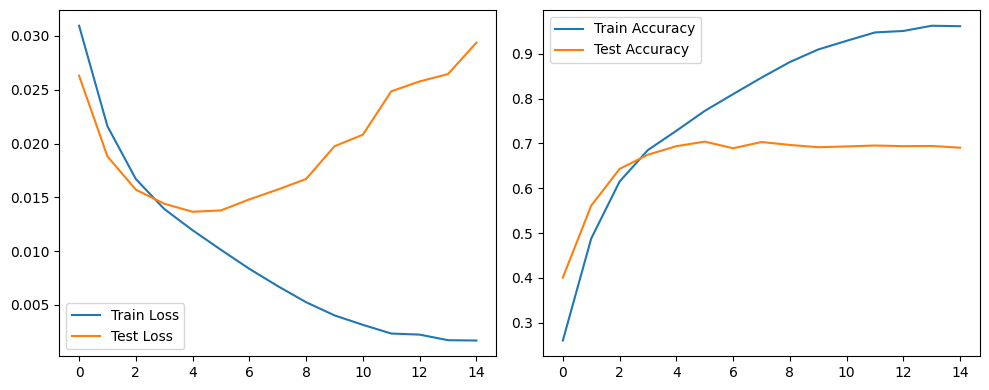

In [598]:
n_epoch = 15
model2_1 = CIFAR_2(3, 16, 10).to('cuda')
loss_fn2_1= torch.nn.CrossEntropyLoss()
optimizer2_1 = torch.optim.Adam(model2_1.parameters())

train_loss2_1, train_acc2_1, test_loss2_1, test_acc2_1 = train_test_loop(n_epoch, model2_1, loss_fn2_1, optimizer2_1, train_loader = train_loader1, test_loader= test_loader1)

In [514]:
summary(model2_1, (16,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR_2                                  [16, 10]                  --
├─Sequential: 1-1                        [16, 10]                  --
│    └─Conv2d: 2-1                       [16, 16, 32, 32]          448
│    └─ReLU: 2-2                         [16, 16, 32, 32]          --
│    └─Conv2d: 2-3                       [16, 16, 32, 32]          2,320
│    └─ReLU: 2-4                         [16, 16, 32, 32]          --
│    └─MaxPool2d: 2-5                    [16, 16, 16, 16]          --
│    └─Dropout2d: 2-6                    [16, 16, 16, 16]          --
│    └─Conv2d: 2-7                       [16, 16, 16, 16]          2,320
│    └─ReLU: 2-8                         [16, 16, 16, 16]          --
│    └─Conv2d: 2-9                       [16, 16, 16, 16]          2,320
│    └─ReLU: 2-10                        [16, 16, 16, 16]          --
│    └─MaxPool2d: 2-11                   [16, 16, 8, 8]            --
│    

嘗試看看不同的 hidden layer 的 neron 數:

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

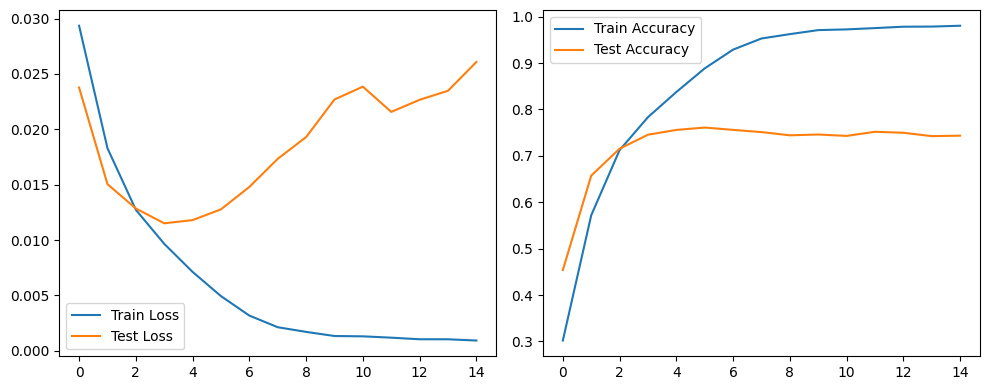

In [737]:
n_epoch = 15
model2_2 = CIFAR_2(3, 64, 10).to('cuda')
loss_fn2_2 = torch.nn.CrossEntropyLoss()
optimizer2_2 = torch.optim.Adam(model2_2.parameters())

train_loss2_2, train_acc2_2, test_loss2_2, test_acc2_2 = train_test_loop(n_epoch, model2_2, loss_fn2_2, optimizer2_2, train_loader = train_loader1, test_loader= test_loader1)

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

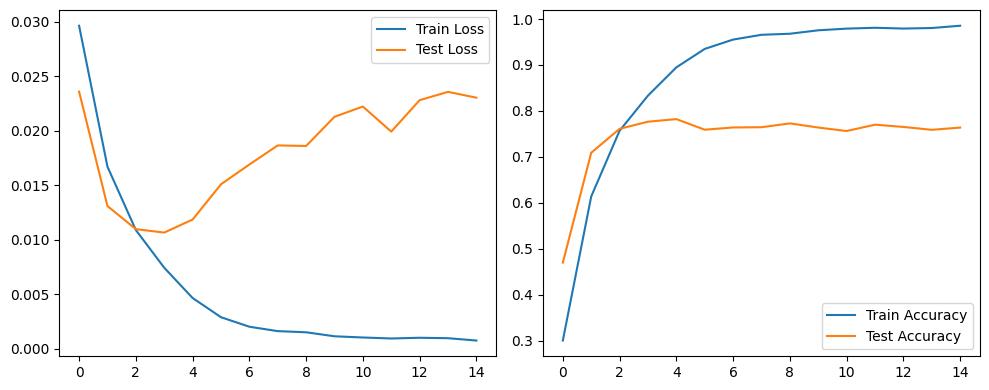

In [742]:
n_epoch = 15
model2_3 = CIFAR_2(3, 256, 10).to('cuda')
loss_fn2_3 = torch.nn.CrossEntropyLoss()
optimizer2_3 = torch.optim.Adam(model2_3.parameters())

train_loss2_3, train_acc2_3, test_loss2_3, test_acc2_3 = train_test_loop(n_epoch, model2_3, loss_fn2_3, optimizer2_3, train_loader = train_loader1, test_loader= test_loader1)

overfitting 似乎沒有變比較好，但是 Accuracy變好了! 不過來試試看 dropout + 模型簡化 :

In [512]:
class CIFAR_21(nn.Module):

    '''
    減少兩層Conv2d
    '''
    
    def __init__(self, input_f, hidden_f, output_f):
        super().__init__()
        self.se1 = nn.Sequential(
            nn.Conv2d(input_f, hidden_f, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.5),
            nn.Conv2d(hidden_f, hidden_f, kernel_size= 3, padding=1),
            nn.ReLU(),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.5),
            nn.Flatten(),
            nn.Linear(8*8*hidden_f, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512,output_f)
        )

    def forward(self,x):
        return self.se1(x)
        

  0%|          | 0/15 [00:00<?, ?it/s]

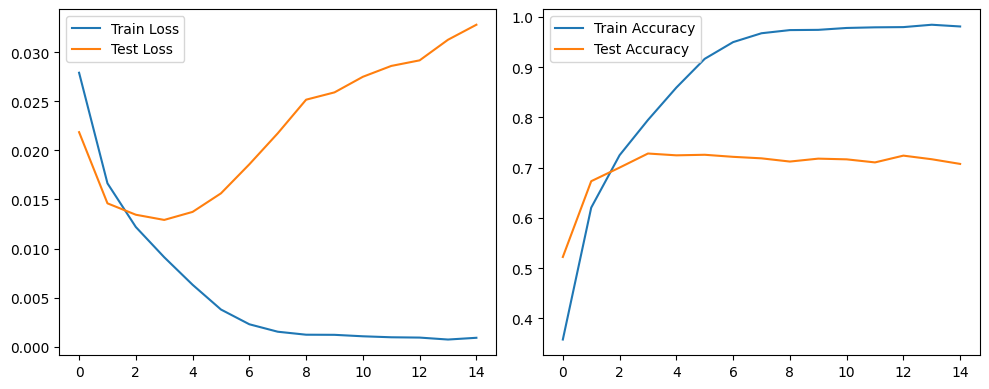

In [760]:
n_epoch = 15
model21_1 = CIFAR_21(3, 64, 10).to('cuda')
loss_fn21_1= torch.nn.CrossEntropyLoss()
optimizer21_1 = torch.optim.Adam(model21_1.parameters())

train_loss21_1, train_acc21_1, test_loss21_1, test_acc21_1 = train_test_loop(n_epoch, model21_1, loss_fn21_1, optimizer21_1, train_loader= train_loader1, test_loader= test_loader1)

In [736]:
summary(model21_1, (16,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
CIFAR_21                                 [16, 10]                  --
├─Sequential: 1-1                        [16, 10]                  --
│    └─Conv2d: 2-1                       [16, 16, 32, 32]          448
│    └─ReLU: 2-2                         [16, 16, 32, 32]          --
│    └─ReLU: 2-3                         [16, 16, 32, 32]          --
│    └─MaxPool2d: 2-4                    [16, 16, 16, 16]          --
│    └─Dropout2d: 2-5                    [16, 16, 16, 16]          --
│    └─Conv2d: 2-6                       [16, 16, 16, 16]          2,320
│    └─ReLU: 2-7                         [16, 16, 16, 16]          --
│    └─ReLU: 2-8                         [16, 16, 16, 16]          --
│    └─MaxPool2d: 2-9                    [16, 16, 8, 8]            --
│    └─Dropout2d: 2-10                   [16, 16, 8, 8]            --
│    └─Flatten: 2-11                     [16, 1024]                --
│    └─Line

嘗試做做看一個更複雜的模型，因為 hidden layer neuron 數是 256 的模型表現較好，但是 deep neuron 其實應該可以做到類似的效果

In [762]:
class CIFAR_22(nn.Module):
        def __init__(self, input_f, hidden_f, output_f):
            super().__init__()
            self.se1 = nn.Sequential(
                nn.Conv2d(input_f, hidden_f, kernel_size= 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_f, hidden_f, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.5),
                nn.Conv2d(hidden_f, hidden_f, kernel_size= 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_f, hidden_f, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.5),
                nn.Conv2d(hidden_f, hidden_f, kernel_size= 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_f, hidden_f, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Dropout2d(0.5),
                nn.Flatten(),
                nn.Linear(4*4*hidden_f, 512),
                nn.ReLU(),
                nn.Linear(512,256),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(256,64),
                nn.ReLU(),
                nn.Linear(64,output_f)    
            )

        def forward(self,x):
            return self.se1(x)

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

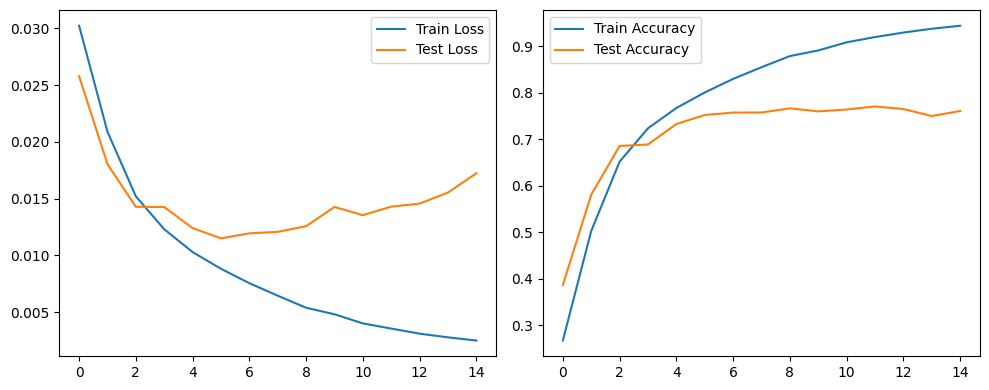

In [763]:
n_epoch = 15
model22_1 = CIFAR_22(3, 64, 10).to('cuda')
loss_fn22_1= torch.nn.CrossEntropyLoss()
optimizer22_1 = torch.optim.Adam(model22_1.parameters())

train_loss22_1, train_acc22_1, test_loss22_1, test_acc22_1 = train_test_loop(n_epoch, model22_1, loss_fn22_1, optimizer22_1, train_loader= train_loader1, test_loader= test_loader1)

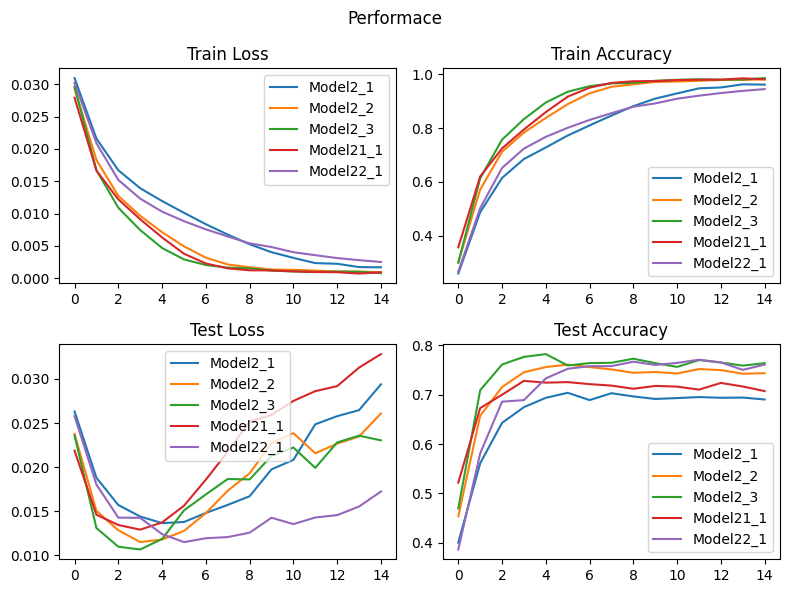

In [764]:
plt.figure(figsize = (8,6))
plt.subplot(2,2,1)
plt.plot(range(15), train_loss2_1, label = 'Model2_1')
plt.plot(range(15), train_loss2_2, label = 'Model2_2')
plt.plot(range(15), train_loss2_3, label = 'Model2_3')
plt.plot(range(15), train_loss21_1, label = 'Model21_1')
plt.plot(range(15), train_loss22_1, label = 'Model22_1')
plt.legend(loc = 'best')
plt.title('Train Loss')

plt.subplot(2,2,2)
plt.plot(range(15), train_acc2_1, label = 'Model2_1')
plt.plot(range(15), train_acc2_2, label = 'Model2_2')
plt.plot(range(15), train_acc2_3, label = 'Model2_3')
plt.plot(range(15), train_acc21_1, label = 'Model21_1')
plt.plot(range(15), train_acc22_1, label = 'Model22_1')
plt.legend(loc = 'best')
plt.title('Train Accuracy')
plt.suptitle('Train Performace')

plt.subplot(2,2,3)
plt.plot(range(15), test_loss2_1, label = 'Model2_1')
plt.plot(range(15), test_loss2_2, label = 'Model2_2')
plt.plot(range(15), test_loss2_3, label = 'Model2_3')
plt.plot(range(15), test_loss21_1, label = 'Model21_1')
plt.plot(range(15), test_loss22_1, label = 'Model22_1')
plt.legend(loc = 'best')
plt.title('Test Loss')

plt.subplot(2,2,4)
plt.plot(range(15), test_acc2_1, label = 'Model2_1')
plt.plot(range(15), test_acc2_2, label = 'Model2_2')
plt.plot(range(15), test_acc2_3, label = 'Model2_3')
plt.plot(range(15), test_acc21_1, label = 'Model21_1')
plt.plot(range(15), test_acc22_1, label = 'Model22_1')
plt.legend(loc = 'best')
plt.title('Test Accuracy')
plt.suptitle('Performace')

plt.tight_layout()

* Loss:
Test Loss 在比較 deep 的 dropout model (model22_1)中表現比較好，但 testing loss 還是有增加的趨勢但較平緩。
* Accuracy:
deep 的 dropout model (model22_1)和 相較之下比較 shallow 但是 hidden layer neuron 數比較多的 model (model2_3) 兩個表現比較好。推論參數量增加可能會讓模型整體表現變好。

## 9.3 Regularization
常見的 Regularization 為 L1 Regularization 和 L2 Regularization，主要作法是對於neuron裡面的Weight做decay。利用對於weight增加限制來換取更加 generalize 的模型。
Pytorch的weight decay 是對 optimizer 來做設定，且 default 設定為 L2 Regularization。
在機器學習中，Regularization是一種用於控制模型複雜度以防止過擬合（overfitting）的技術。過擬合指的是模型在訓練數據上表現良好，但在測試數據上表現較差，這是因為模型在訓練過程中過度擬合了訓練數據中的噪聲或局部特徵。Regularization通常通過向目標函數添加一個額外的懲罰項來實現，這個懲罰項與模型參數的大小有關。這樣做的效果是，當模型參數的值變得過大時，懲罰項會增加目標函數的值，從而促使模型更加平滑或簡單。 正則化的目標是在訓練過程中找到更平滑的解，從而降低對訓練數據的過度擬合，提高模型在新數據上的泛化能力。 

  0%|          | 0/15 [00:00<?, ?it/s]

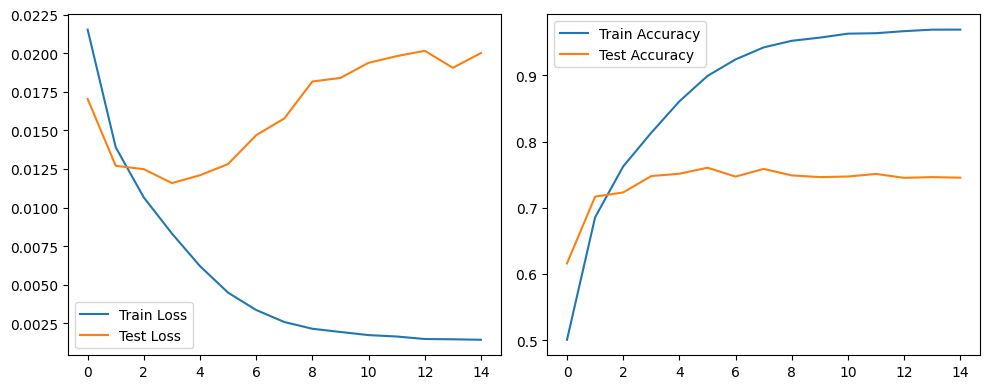

In [750]:
# 先用一開始的 model 來做做看
model3_1 = CIFAR(3, 64, 10)
loss_fn3_1 = torch.nn.CrossEntropyLoss()
optimizer3_1 = torch.optim.Adam(model3_1.parameters(), weight_decay=1e-4)

train_loss3_1, train_acc3_1, test_loss3_1, test_acc3_1 = train_test_loop(n_epoch, model3_1, loss_fn3_1, optimizer3_1, train_loader = train_loader1, test_loader = test_loader1)


看起來 overfitting有稍作緩解，調整l2 regularization看看:

  0%|          | 0/15 [00:00<?, ?it/s]

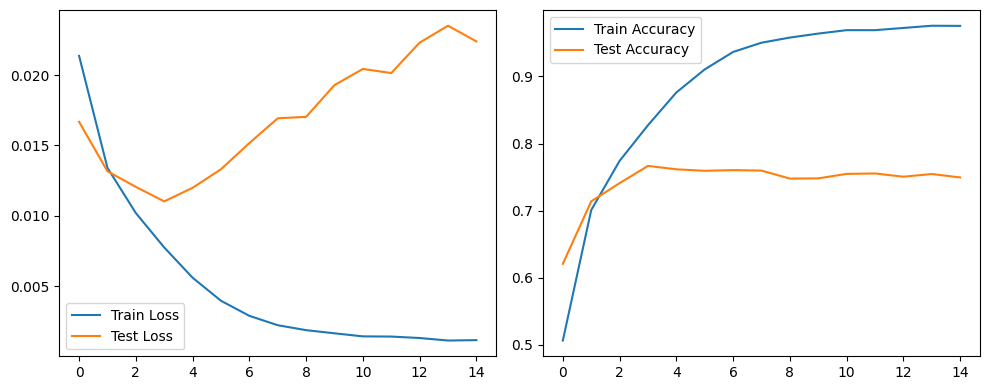

In [751]:
model3_2 = CIFAR(3, 64, 10)
loss_fn3_2 = torch.nn.CrossEntropyLoss()
optimizer3_2 = torch.optim.Adam(model3_2.parameters(), weight_decay=5e-5)

train_loss3_2, train_acc3_2, test_loss3_2, test_acc3_2 = train_test_loop(n_epoch, model3_2, loss_fn3_2, optimizer3_2, train_loader = train_loader1, test_loader = test_loader1)


weight decay的數字對兩個模型來看差異不大，用簡化模型來試試看

  0%|          | 0/15 [00:00<?, ?it/s]

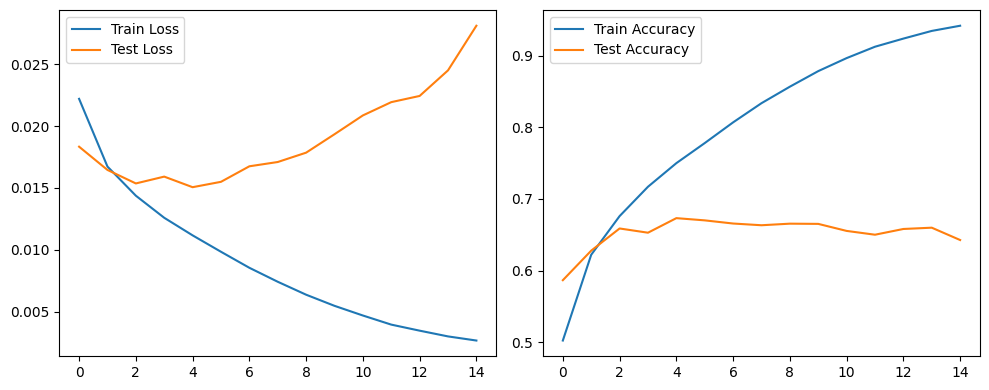

In [752]:
# 對簡化的 model 進行 L2 Regularization

model3_3 = CIFAR_1(3, 64, 10)
loss_fn3_3 = torch.nn.CrossEntropyLoss()
optimizer3_3 = torch.optim.Adam(model3_3.parameters(), weight_decay=5e-5)

train_loss3_3, train_acc3_3, test_loss3_3, test_acc3_3 = train_test_loop(n_epoch, model3_3, loss_fn3_3, optimizer3_3, train_loader = train_loader1, test_loader = test_loader1)


簡化模型表現並沒有比原始模型好，改用drop out model來看:

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

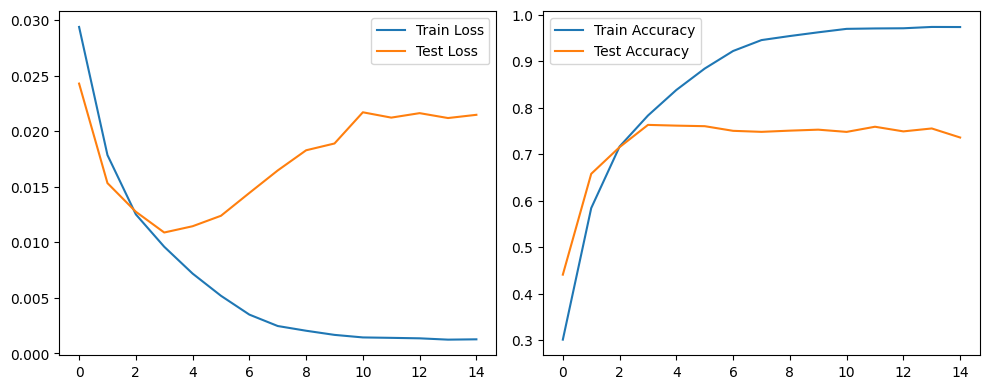

In [766]:
# 對 dropout model 做 L2 Regularization
n_epoch = 15
model3_4 = CIFAR_2(3, 64, 10).to('cuda')
loss_fn3_4= torch.nn.CrossEntropyLoss()
optimizer3_4 = torch.optim.Adam(model3_4.parameters(), weight_decay= 5e-5)

train_loss3_4, train_acc3_4, test_loss3_4, test_acc3_4 = train_test_loop(n_epoch, model3_4, loss_fn3_4, optimizer3_4, train_loader = train_loader1, test_loader = test_loader1)

  0%|          | 0/15 [00:00<?, ?it/s]

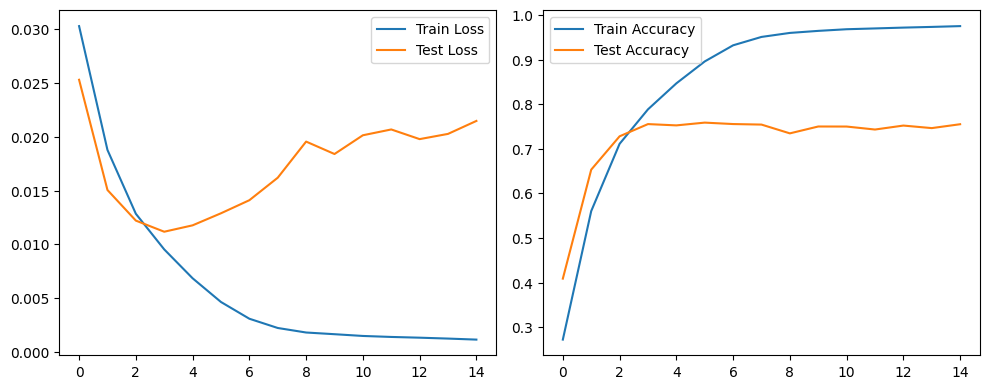

In [767]:
# 對 dropout model 做 L2 Regularization
n_epoch = 15
model3_5 = CIFAR_2(3, 128, 10).to('cuda')
loss_fn3_5= torch.nn.CrossEntropyLoss()
optimizer3_5 = torch.optim.Adam(model3_5.parameters(), weight_decay= 5e-5)

train_loss3_5, train_acc3_5, test_loss3_5, test_acc3_5 = train_test_loop(n_epoch, model3_5, loss_fn3_5, optimizer3_5, train_loader = train_loader1, test_loader = test_loader1)

SGD 也是常用的 optimizer ，這邊將 optimizer 從 Adam 改成 SGD 並增加 L2 regularization 看看:

  0%|          | 0/15 [00:00<?, ?it/s]

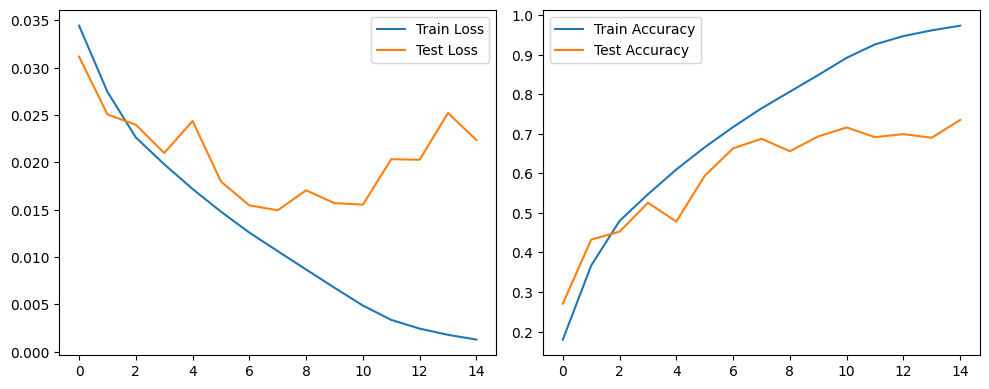

In [748]:
n_epoch = 15
model3_6 = CIFAR_2(3, 64, 10).to('cuda')
loss_fn3_6= torch.nn.CrossEntropyLoss()
optimizer3_6 = torch.optim.SGD(model3_6.parameters(), lr = 3e-2, weight_decay= 5e-5)

train_loss3_6, train_acc3_6, test_loss3_6, test_acc3_6 = train_test_loop(n_epoch, model3_6, loss_fn3_6, optimizer3_6, train_loader = train_loader1, test_loader = test_loader1)

  0%|          | 0/15 [00:00<?, ?it/s]

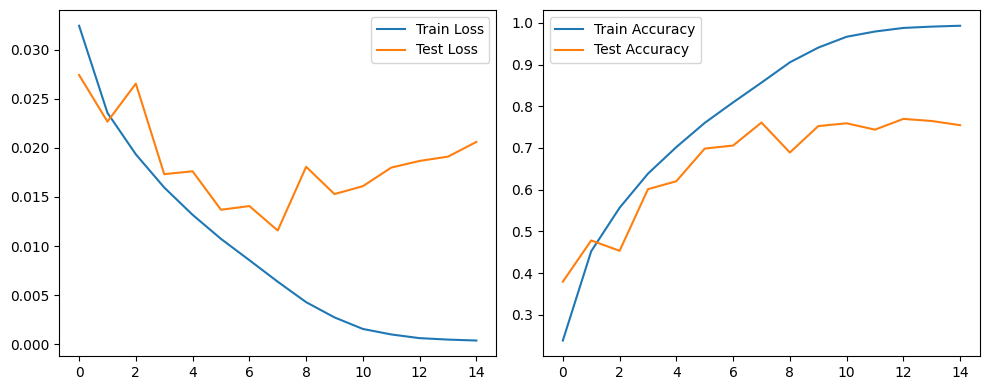

In [769]:
n_epoch = 15
model3_7 = CIFAR_2(3, 256, 10).to('cuda')
loss_fn3_7= torch.nn.CrossEntropyLoss()
optimizer3_7 = torch.optim.SGD(model3_7.parameters(), lr = 3e-2, weight_decay= 5e-5)

train_loss3_7, train_acc3_7, test_loss3_7, test_acc3_7 = train_test_loop(n_epoch, model3_7, loss_fn3_7, optimizer3_7, train_loader = train_loader1, test_loader = test_loader1)

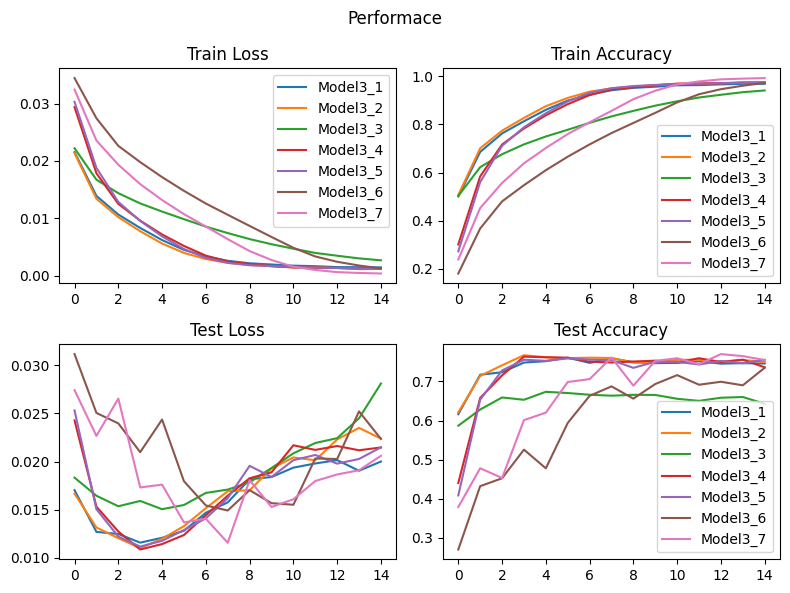

In [811]:
plt.figure(figsize = (8,6))
plt.subplot(2,2,1)
plt.plot(range(15), train_loss3_1, label = 'Model3_1')
plt.plot(range(15), train_loss3_2, label = 'Model3_2')
plt.plot(range(15), train_loss3_3, label = 'Model3_3')
plt.plot(range(15), train_loss3_4, label = 'Model3_4')
plt.plot(range(15), train_loss3_5, label = 'Model3_5')
plt.plot(range(15), train_loss3_6, label = 'Model3_6')
plt.plot(range(15), train_loss3_7, label = 'Model3_7')
plt.legend(loc = 'best')
plt.title('Train Loss')

plt.subplot(2,2,2)
plt.plot(range(15), train_acc3_1, label = 'Model3_1')
plt.plot(range(15), train_acc3_2, label = 'Model3_2')
plt.plot(range(15), train_acc3_3, label = 'Model3_3')
plt.plot(range(15), train_acc3_4, label = 'Model3_4')
plt.plot(range(15), train_acc3_5, label = 'Model3_5')
plt.plot(range(15), train_acc3_6, label = 'Model3_6')
plt.plot(range(15), train_acc3_7, label = 'Model3_7')
plt.legend(loc = 'best')
plt.title('Train Accuracy')
plt.suptitle('Train Performace')

plt.subplot(2,2,3)
plt.plot(range(15), test_loss3_1, label = 'Model3_1')
plt.plot(range(15), test_loss3_2, label = 'Model3_2')
plt.plot(range(15), test_loss3_3, label = 'Model3_3')
plt.plot(range(15), test_loss3_4, label = 'Model3_4')
plt.plot(range(15), test_loss3_5, label = 'Model3_5')
plt.plot(range(15), test_loss3_6, label = 'Model3_6')
plt.plot(range(15), test_loss3_7, label = 'Model3_7')
plt.title('Test Loss')

plt.subplot(2,2,4)
plt.plot(range(15), test_acc3_1, label = 'Model3_1')
plt.plot(range(15), test_acc3_2, label = 'Model3_2')
plt.plot(range(15), test_acc3_3, label = 'Model3_3')
plt.plot(range(15), test_acc3_4, label = 'Model3_4')
plt.plot(range(15), test_acc3_5, label = 'Model3_5')
plt.plot(range(15), test_acc3_6, label = 'Model3_6')
plt.plot(range(15), test_acc3_7, label = 'Model3_7')
plt.legend(loc = 'best')
plt.title('Test Accuracy')
plt.suptitle('Performace')

plt.tight_layout()

## 9.4 Data Augmentation
在資料量不大的狀況下，若僅以 training data 來建立 model 可能 training的多樣性不足而使 model 無法　generalize 到沒有看過的資料。 Data Augmentation 會將資料做加工來增加資料的多樣性。通過對訓練數據集進行變換或轉換來增加數據量的技術。這些變換可以包括圖像的旋轉、縮放、平移、翻轉、裁剪、色彩調整等操作，對於其他類型的數據，也可以有相應的變換方式。透過數據擴增，可以有效地擴展訓練數據集，從而提高模型的泛化能力和抗干擾能力。同時，它也有助於減輕過擬合現象，因為模型在訓練過程中將面對更多多樣化的數據，而不僅僅是原始的訓練數據。數據擴增在圖像識別、自然語言處理等領域都有廣泛的應用，並且通常與其他正則化技術（如dropout和正則化）一起使用，以提高模型的性能和穩定性。

In [499]:
transform_a = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.AutoAugment(),
    torchvision.transforms.ToTensor(), #將RPG資料全部/255變成(0,1)的數字
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))    
])

In [786]:
train1_a = torchvision.datasets.CIFAR10(root = path, train = True, download = False, transform = transform_a)
test1_a = torchvision.datasets.CIFAR10(root = path, train = False, download = False, transform = transform_n)

In [787]:
img3, label3 = train1_a[0]
img3, label3, img3.shape

(tensor([[[-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
          [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
          [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
          ...,
          [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
          [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895],
          [-1.9895, -1.9895, -1.9895,  ..., -1.9895, -1.9895, -1.9895]],
 
         [[-1.9803, -1.9803, -1.9803,  ..., -1.9803, -1.9803, -1.9803],
          [-1.9803, -1.9803, -1.9803,  ..., -1.9803, -1.9803, -1.9803],
          [-1.9803, -1.9803, -1.9803,  ..., -1.9803, -1.9803, -1.9803],
          ...,
          [-1.9803, -1.9803, -1.9803,  ..., -1.9803, -1.9803, -1.9803],
          [-1.9803, -1.9803, -1.9803,  ..., -1.9803, -1.9803, -1.9803],
          [-1.9803, -1.9803, -1.9803,  ..., -1.9803, -1.9803, -1.9803]],
 
         [[-1.7068, -1.7068, -1.7068,  ..., -1.7068, -1.7068, -1.7068],
          [-1.7068, -1.7068,

In [788]:
train_loader2 = torch.utils.data.DataLoader(train1_a, batch_size = 64, shuffle = True)
test_loader2 = torch.utils.data.DataLoader(test1_a, batch_size = 64, shuffle = False)

In [789]:
train_loader3 = torch.utils.data.DataLoader(train1_a, batch_size = 128, shuffle = True)
test_loader3 = torch.utils.data.DataLoader(test1_a, batch_size = 128, shuffle = False)

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

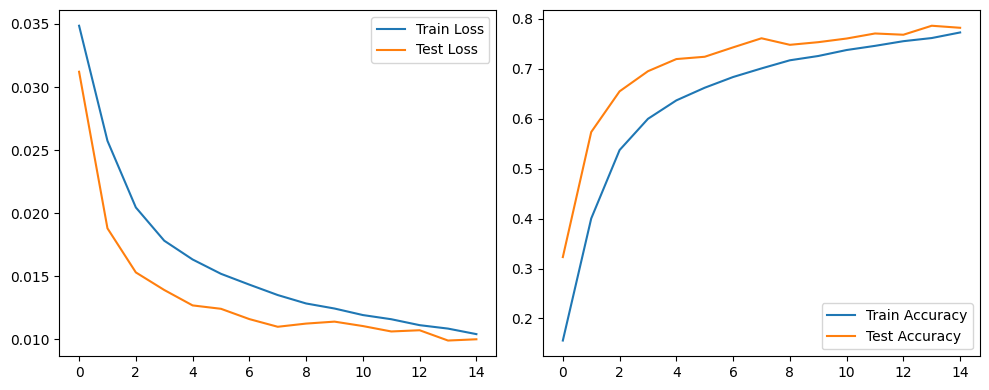

In [814]:
# 用作後一個 dropout + L2 Regulariztion 的模型來跑跑看 data augmentation 的 dataset
n_epoch = 15
model4_0 = CIFAR_2(3, 128, 10).to('cuda')
loss_fn4_0= torch.nn.CrossEntropyLoss()
optimizer4_0 = torch.optim.Adam(model4_0.parameters())

train_loss4_0, train_acc4_0, test_loss4_0, test_acc4_0 = train_test_loop(n_epoch, model4_0, loss_fn4_0, optimizer4_0, train_loader = train_loader2, test_loader = test_loader2)

  0%|          | 0/15 [00:00<?, ?it/s]

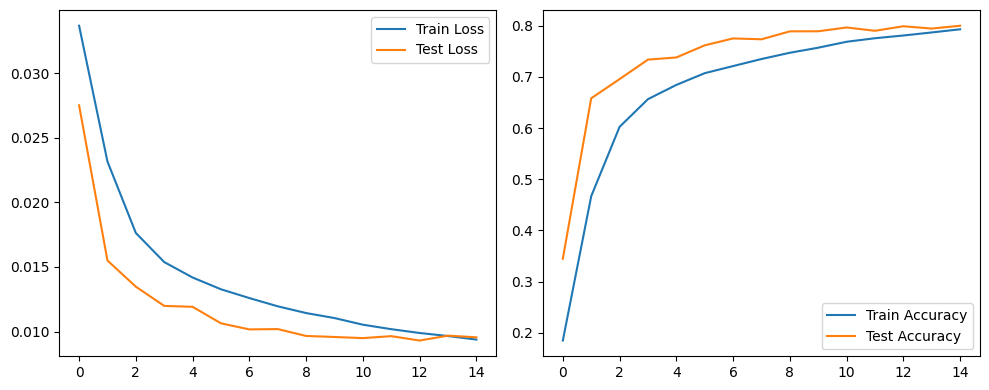

In [791]:
# 用作後一個 dropout + L2 Regulariztion 的模型來跑跑看 data augmentation 的 dataset
n_epoch = 15
model4_1 = CIFAR_2(3, 64, 10).to('cuda')
loss_fn4_1= torch.nn.CrossEntropyLoss()
optimizer4_1 = torch.optim.Adam(model4_1.parameters(), weight_decay= 5e-5)

train_loss4_1, train_acc4_1, test_loss4_1, test_acc4_1 = train_test_loop(n_epoch, model4_1, loss_fn4_1, optimizer4_1, train_loader = train_loader2, test_loader = test_loader2)

看起來 overfitting的問題得到了一些改善，且testing accuracy 到了80%，嘗試修改 model 的 hidden layer 數量看看是否可以得到更好的成果。

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

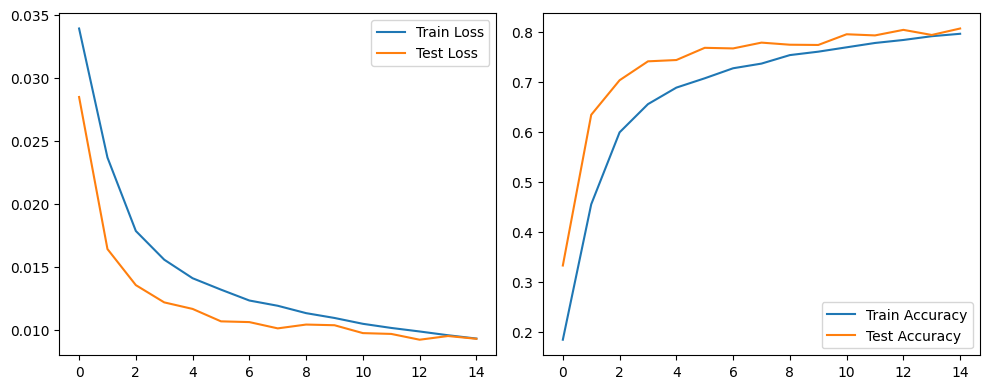

In [793]:
n_epoch = 15
model4_2 = CIFAR_2(3, 128, 10).to('cuda')
loss_fn4_2 = torch.nn.CrossEntropyLoss()
optimizer4_2 = torch.optim.Adam(model4_2.parameters(), weight_decay= 5e-5)

train_loss4_2, train_acc4_2, test_loss4_2, test_acc4_2 = train_test_loop(n_epoch, model4_2, loss_fn4_2, optimizer4_2, train_loader = train_loader2, test_loader= test_loader2)

把比較多層的那個 dropout 模型加上 data augmentation 的 Dataset 試試:

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

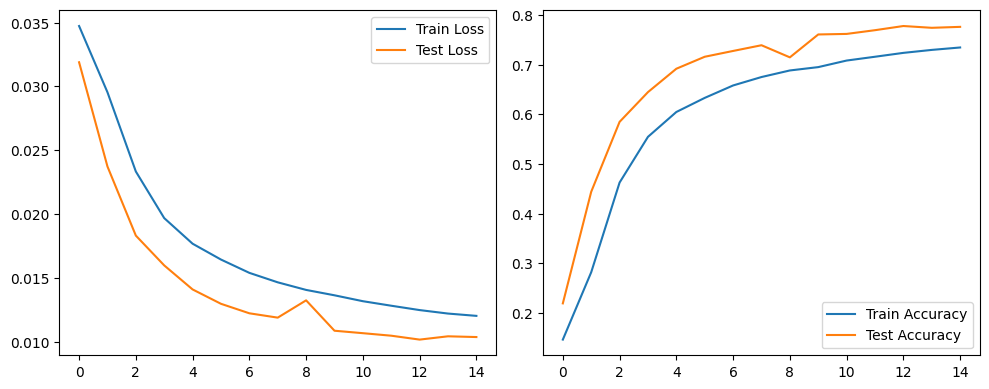

In [794]:
n_epoch = 15
model4_3 = CIFAR_22(3, 128, 10).to('cuda')
loss_fn4_3 = torch.nn.CrossEntropyLoss()
optimizer4_3 = torch.optim.Adam(model4_3.parameters(), weight_decay= 5e-5)

train_loss4_3, train_acc4_3, test_loss4_3, test_acc4_3 = train_test_loop(n_epoch, model4_3, loss_fn4_3, optimizer4_3, train_loader = train_loader2, test_loader= test_loader2)

增加 hidden layer neuron 和 epoch:

  0%|          | 0/30 [00:00<?, ?it/s]

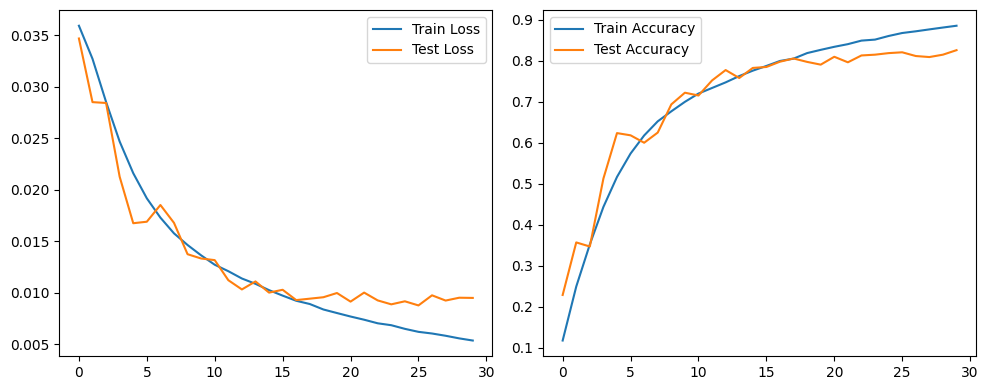

In [795]:
n_epoch = 30
model4_4 = CIFAR_2(3, 128, 10).to('cuda')
loss_fn4_4 = torch.nn.CrossEntropyLoss()
optimizer4_4 = torch.optim.SGD(model4_4.parameters(), lr = 3e-2, weight_decay= 5e-5)

train_loss4_4, train_acc4_4, test_loss4_4, test_acc4_4 = train_test_loop(n_epoch, model4_4, loss_fn4_4, optimizer4_4, train_loader = train_loader2, test_loader= test_loader2)

嘗試更改 batch size

C:\Users\HSUPC\anaconda3\envs\pytorch1\lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/15 [00:00<?, ?it/s]

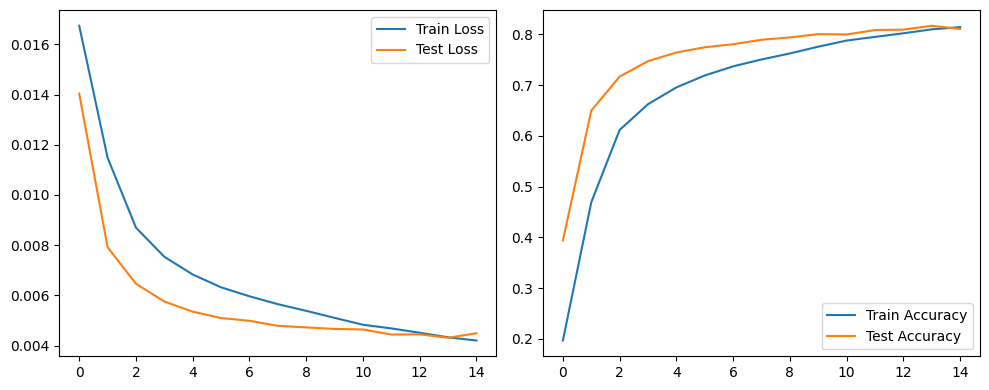

In [801]:
n_epoch = 15
model4_5 = CIFAR_2(3, 128, 10).to('cuda')
loss_fn4_5 = torch.nn.CrossEntropyLoss()
optimizer4_5 = torch.optim.Adam(model4_5.parameters(), weight_decay=5e-5)

train_loss4_5, train_acc4_5, test_loss4_5, test_acc4_5 = train_test_loop(n_epoch, model4_5, loss_fn4_5, optimizer4_5, train_loader = train_loader3, test_loader= test_loader3)

  0%|          | 0/30 [00:00<?, ?it/s]

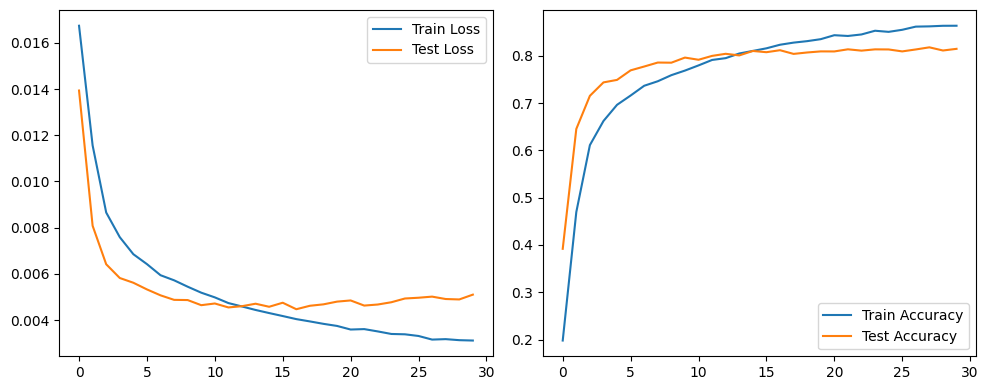

In [806]:
n_epoch = 30
model4_6 = CIFAR_2(3, 128, 10).to('cuda')
loss_fn4_6 = torch.nn.CrossEntropyLoss()
optimizer4_6 = torch.optim.Adam(model4_6.parameters(), weight_decay=5e-5)

train_loss4_6, train_acc4_6, test_loss4_6, test_acc4_6 = train_test_loop(n_epoch, model4_6, loss_fn4_6, optimizer4_6, train_loader = train_loader3, test_loader= test_loader3)

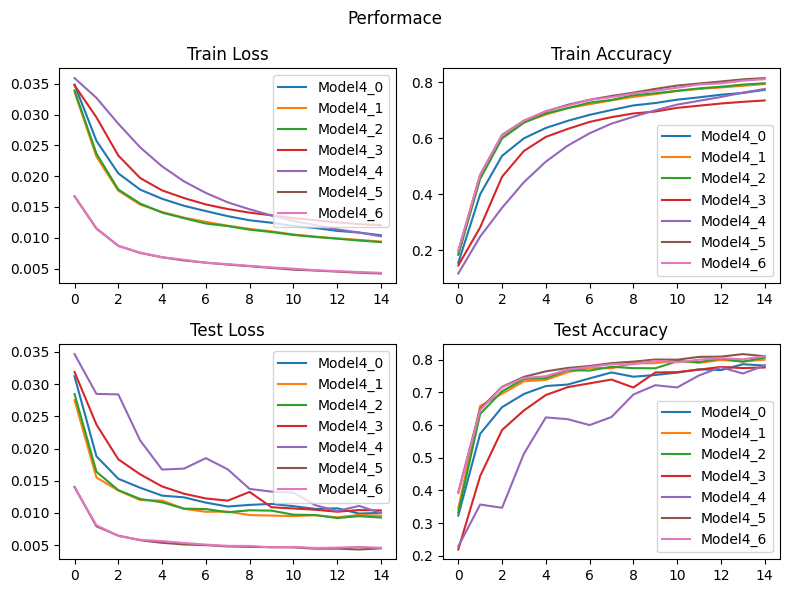

In [816]:
plt.figure(figsize = (8,6))
plt.subplot(2,2,1)
plt.plot(range(15), train_loss4_0, label = 'Model4_0')
plt.plot(range(15), train_loss4_1, label = 'Model4_1')
plt.plot(range(15), train_loss4_2, label = 'Model4_2')
plt.plot(range(15), train_loss4_3, label = 'Model4_3')
plt.plot(range(15), train_loss4_4[:15], label = 'Model4_4')
plt.plot(range(15), train_loss4_5, label = 'Model4_5')
plt.plot(range(15), train_loss4_6[:15], label = 'Model4_6')
plt.legend(loc = 'best')
plt.title('Train Loss')

plt.subplot(2,2,2)
plt.plot(range(15), train_acc4_0, label = 'Model4_0')
plt.plot(range(15), train_acc4_1, label = 'Model4_1')
plt.plot(range(15), train_acc4_2, label = 'Model4_2')
plt.plot(range(15), train_acc4_3, label = 'Model4_3')
plt.plot(range(15), train_acc4_4[:15], label = 'Model4_4')
plt.plot(range(15), train_acc4_5, label = 'Model4_5')
plt.plot(range(15), train_acc4_6[:15], label = 'Model4_6')
plt.legend(loc = 'best')
plt.title('Train Accuracy')
plt.suptitle('Train Performace')

plt.subplot(2,2,3)
plt.plot(range(15), test_loss4_0, label = 'Model4_0')
plt.plot(range(15), test_loss4_1, label = 'Model4_1')
plt.plot(range(15), test_loss4_2, label = 'Model4_2')
plt.plot(range(15), test_loss4_3, label = 'Model4_3')
plt.plot(range(15), test_loss4_4[:15], label = 'Model4_4')
plt.plot(range(15), test_loss4_5, label = 'Model4_5')
plt.plot(range(15), test_loss4_6[:15], label = 'Model4_6')
plt.legend(loc = 'best')
plt.title('Test Loss')

plt.subplot(2,2,4)
plt.plot(range(15), test_acc4_0, label = 'Model4_0')
plt.plot(range(15), test_acc4_1, label = 'Model4_1')
plt.plot(range(15), test_acc4_2, label = 'Model4_2')
plt.plot(range(15), test_acc4_3, label = 'Model4_3')
plt.plot(range(15), test_acc4_4[:15], label = 'Model4_4')
plt.plot(range(15), test_acc4_5, label = 'Model4_5')
plt.plot(range(15), test_acc4_6[:15], label = 'Model4_6')
plt.legend(loc = 'best')
plt.title('Test Accuracy')
plt.suptitle('Performace')

plt.tight_layout()

# 10. 模型儲存

In [823]:
torch.save(model4_5.state_dict(), 'CIFAR10_model.pt')

In [828]:
model10 = CIFAR_2(3, 128, 10).to('cuda')
loss_fn10 = torch.nn.CrossEntropyLoss()
optimizer10 = torch.optim.Adam(model10.parameters(), weight_decay= 5e-5)

model10.load_state_dict(torch.load('CIFAR10_model.pt'))

<All keys matched successfully>

In [841]:
model10.eval()
test_loss10, test_acc10, test_total10 = 0, 0, 0
prediction10 = []

with torch.inference_mode():
    for img10, label10 in test_loader3:
        img10, label10 = img10.to('cuda'), label10.to('cuda')
        output10 = model10(img10)
        loss10 = loss_fn10(output10, label10)
        pre10 = torch.argmax(output10.squeeze(), dim = 1)

        test_loss10 += loss10.item()
        test_acc10 += int((pre10 == label10).sum())
        test_total10 += len(label10)

        prediction10.append(pre10)

prediction10 = torch.cat(prediction10)

print(f'Test Loss: {test_loss10/test_total10 : 2.3f}; Test Accuracy: {test_acc10/test_total10 : 2.3f}')
    

Test Loss:  0.004; Test Accuracy:  0.811


In [852]:
prediction10[:10]

tensor([3, 8, 1, 0, 6, 6, 1, 6, 3, 1], device='cuda:0')

In [847]:
test1_a.targets[:10]

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1]

# 11. Confusion Matrix

In [833]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [835]:
fc = ConfusionMatrix('multiclass', num_classes=10)

In [854]:
confusion_matrix = fc(prediction10.to('cpu'), torch.Tensor(test1_a.targets))

In [855]:
confusion_matrix

tensor([[854,   5,  32,  18,   4,   1,   8,  11,  61,   6],
        [ 16, 908,   3,   6,   1,   3,   4,   1,  11,  47],
        [ 67,   2, 727,  56,  27,  33,  58,  18,  11,   1],
        [ 19,   6,  45, 723,  31,  89,  45,  33,   6,   3],
        [ 16,   1,  72,  49, 709,  24,  57,  64,   7,   1],
        [ 11,   0,  37, 222,  16, 641,  17,  52,   3,   1],
        [ 12,   0,  29,  57,   9,  10, 870,   6,   7,   0],
        [ 11,   0,  19,  35,  12,  22,   6, 889,   4,   2],
        [ 43,  11,  12,   6,   3,   2,   6,   1, 906,  10],
        [ 21,  40,   5,  12,   2,   0,   6,   5,  30, 879]])

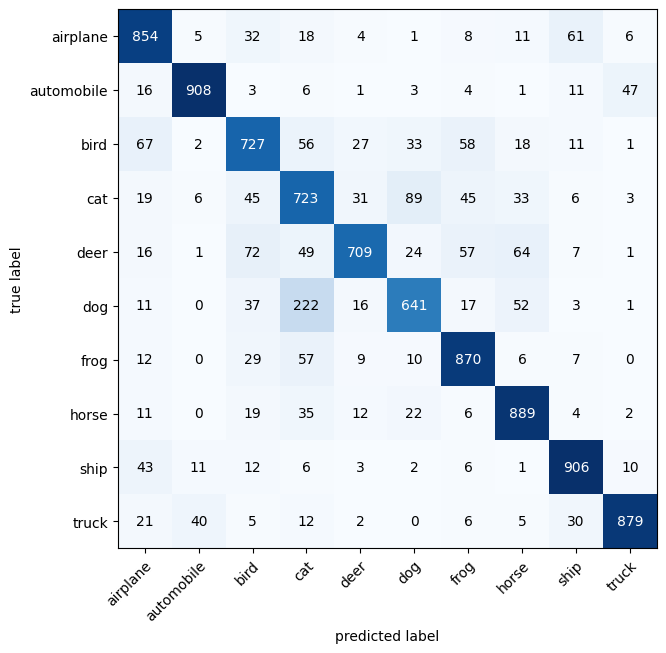

In [856]:
fig, ax = plot_confusion_matrix(
    confusion_matrix.numpy(),
    class_names= test1_a.classes,
    figsize= (10,7)
)

In [857]:
def print_predict(num, data, model):

    # plt.figure(figsize=(5,8))
    model.eval()
    model = model.to('cpu')
    with torch.inference_mode():
        for i in range(num):
            idx = random.randint(0, len(data))
            img, label = data[idx]

            pre_logit = model(img.unsqueeze(0))
            pre = torch.argmax(pre_logit, dim = 1)

                
            plt.subplot((num//5+1), 5, (i+1))
            plt.imshow(img.permute(1,2,0))
    
            if label == pre:
                plt.title(f'Ans: {data.classes[label]} \npre: {data.classes[pre]}', color = 'green', size = 8 )
            else:
                plt.title(f'Ans: {data.classes[label]} \npre: {data.classes[pre]}', color = 'red',size = 8 )
            plt.axis(False)

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

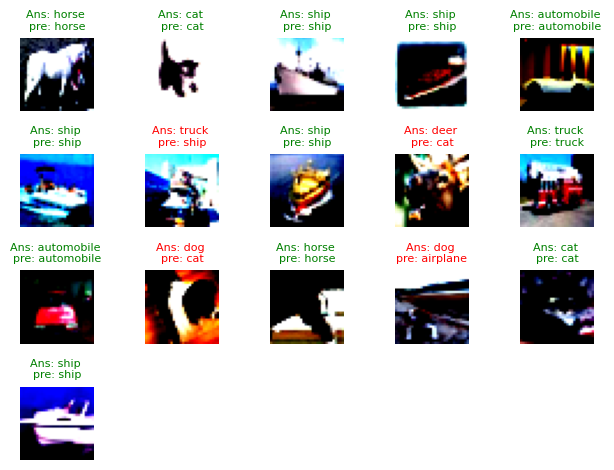

In [859]:
print_predict(16, test1_a, model10)

# 12. 結論


由於嘗試的 Model 數量很多，就每個方法中最佳的模型來做比較:

* Model1_2 : 簡化模型。由於原始模型跑出來的 Loss 有 Overfitting 的傾向，用簡化模型來試試看是否是因為模型過於複雜使模型無法泛化。
* Model2_3 : Dropout。另外調整模型的 hidden layer neron 的數字後達到較高的 Testing accuracy。
* Model3_7 : L2 Regularization + Dropout。整體表現和 Model2_3 差異不大。
* Model4_5 : Data Augmentation + L2 Regularization + Dropout 。 當資料增加 data augmentation 之後，很明顯 Testing loss 持續下降，且accuracy 也是所有model裡面表現最好的。除此之外，調整 batch size 後 testing loss 表現變好，由於較大的 batch size 會使 gradient descent 變平滑而有利於模型收斂 (但同時也會使模型的參數隨機性減少)，但就這個模型結果而言，data augmentation 與 batch size 的調整對模型表現改善有較大的影響。
* 從上述方法來看，資料的改變對模型的表現影響是幾個方法中最大的(但也可能是受到 transform.Autoaugment 的參數在設計的時候就有以 CIFAR10 資料集來做有關)。
* 在使用個個方法當中，hidden layer neuron 數量、模型 deep 的程度、optimizer、L2 Regularization、batch size 等等都是需要不對測試的 hyper paramters，但就算丟進 GPU，參數量較大的 model 也會使整體 runtime 增加。
* 其他可以幫助降低 overfitting 的方法還有增加資料、選擇 feature (通常是 Fully connected network) 與 batch normalize 等

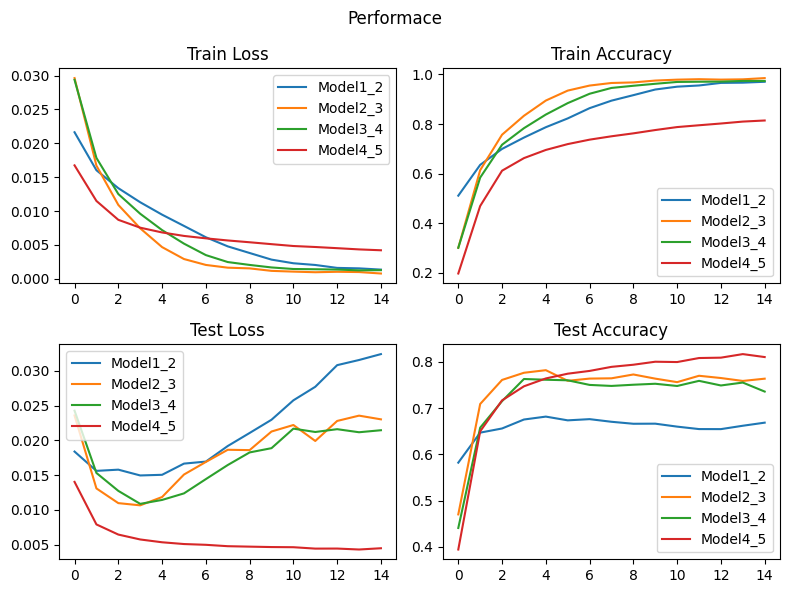

In [813]:
plt.figure(figsize = (8,6))
plt.subplot(2,2,1)
plt.plot(range(15), train_loss1_2, label = 'Model1_2')
plt.plot(range(15), train_loss2_3, label = 'Model2_3')
plt.plot(range(15), train_loss3_4, label = 'Model3_4')
plt.plot(range(15), train_loss4_5, label = 'Model4_5')
plt.legend(loc = 'best')
plt.title('Train Loss')

plt.subplot(2,2,2)
plt.plot(range(15), train_acc1_2, label = 'Model1_2')
plt.plot(range(15), train_acc2_3, label = 'Model2_3')
plt.plot(range(15), train_acc3_4, label = 'Model3_4')
plt.plot(range(15), train_acc4_5, label = 'Model4_5')
plt.legend(loc = 'best')
plt.title('Train Accuracy')
plt.suptitle('Train Performace')

plt.subplot(2,2,3)
plt.plot(range(15), test_loss1_2, label = 'Model1_2')
plt.plot(range(15), test_loss2_3, label = 'Model2_3')
plt.plot(range(15), test_loss3_4, label = 'Model3_4')
plt.plot(range(15), test_loss4_5, label = 'Model4_5')
plt.legend(loc = 'best')
plt.title('Test Loss')

plt.subplot(2,2,4)
plt.plot(range(15), test_acc1_2, label = 'Model1_2')
plt.plot(range(15), test_acc2_3, label = 'Model2_3')
plt.plot(range(15), test_acc3_4, label = 'Model3_4')
plt.plot(range(15), test_acc4_5, label = 'Model4_5')
plt.legend(loc = 'best')
plt.title('Test Accuracy')
plt.suptitle('Performace')

plt.tight_layout()